In [28]:
import numpy as np
import matplotlib.pyplot as plt

In [29]:
def generate_arrow(a, b, gamma):
    sorted_a = np.sort(a)
    n = a.shape[0] + 1
    arrow = np.zeros((n, n))
    if not np.all(np.greater(b, 0)):
        raise UserWarning("All of b's entries must be > 0")
    diag_arrow = np.concatenate((a, np.array([gamma])))
    np.fill_diagonal(arrow, diag_arrow)
    arrow[-1, :n - 1] = b
    arrow[:n - 1, -1] = b.T
    return arrow

In [30]:
a = np.array([20, 19, 18, 17, 16, 15, 14, 13, 12])
b = np.array([10, 9, 8, 7, 6, 5, 4, 3, 2])
gamma = 1
test_arrow = generate_arrow(a, b, gamma)
n = a.shape[0] + 1

In [31]:
test_arrow

array([[ 20.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  10.],
       [  0.,  19.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   9.],
       [  0.,   0.,  18.,   0.,   0.,   0.,   0.,   0.,   0.,   8.],
       [  0.,   0.,   0.,  17.,   0.,   0.,   0.,   0.,   0.,   7.],
       [  0.,   0.,   0.,   0.,  16.,   0.,   0.,   0.,   0.,   6.],
       [  0.,   0.,   0.,   0.,   0.,  15.,   0.,   0.,   0.,   5.],
       [  0.,   0.,   0.,   0.,   0.,   0.,  14.,   0.,   0.,   4.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,  13.,   0.,   3.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  12.,   2.],
       [ 10.,   9.,   8.,   7.,   6.,   5.,   4.,   3.,   2.,   1.]])

In [32]:
def spectral_func(a, b, gamma, lamb):
    b_sqr = np.power(b, 2)
    sum_term = np.sum(b_sqr / (a - lamb))
    return lamb - gamma + sum_term

In [33]:
def spectral_func_prime(a, b, lamb):
    b_sqr = np.power(b, 2)
    a_minus_lamb_sqr = np.power(a - lamb, 2)
    sum_term = np.sum(b_sqr / a_minus_lamb_sqr)
    return 1 + sum_term

In [34]:
# Verification for the result yielded by the program in cuda C:
x = np.zeros((n, ))
for i in range(1, n-1):
    x[i] = (a[i - 1] + a[i]) / 2
x[0] = a[0] + 5
x[n-1] = a[n-2] -5
print(x)
print([spectral_func(a, b, gamma, t) for t in x])
print([spectral_func_prime(a, b, t) for t in x])

[ 25.   19.5  18.5  17.5  16.5  15.5  14.5  13.5  12.5   7. ]
[-33.780094905094899, -26.434976134976132, 58.14983904983908, 99.201298701298697, 118.61111111111109, 124.72222222222223, 121.96753246753248, 113.23411033411033, 100.77250527250527, 42.871203796203794]
[10.234591937435967, 766.27084233830828, 656.20535722291299, 526.8827982983828, 405.17104560342653, 297.44593600403124, 206.01027491988529, 131.85393257178805, 75.280279728165183, 4.7447416528554136]


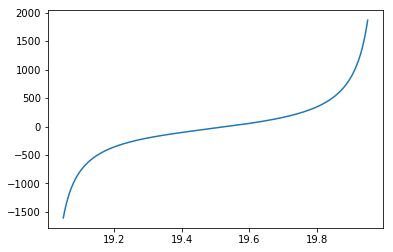

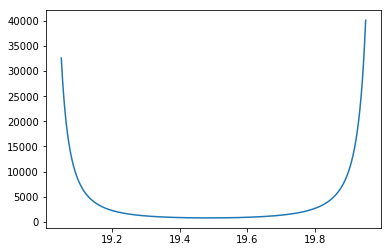

In [35]:
# Plot the functions between a[0] and a[1]
test_spectral = lambda x: spectral_func(a, b, gamma, x)

# Prime derivative
test_spectral_prime = lambda x: spectral_func_prime(a, b, x)

# Slight perturbation to avoid divergence on the plot
epsilon = 0.05
linspace = np.linspace(a[1] + epsilon, a[0] - epsilon, 10000)

# Compute the values and plot the original function
values = [test_spectral(x) for x in linspace]
plt.figure()
plt.plot(linspace, values)

# Compute the values and plot the derivative
values_prime = [test_spectral_prime(x) for x in linspace]
plt.figure()
plt.plot(linspace, values_prime)

# Show
plt.show()

In [36]:
def interior_sigma_coef(a, b, gamma, x, k):
    first_term = 3 * x - (gamma + a[k - 1] + a[k])
    to_sum1 = np.power(b, 2) / (a - x)
    to_sum2 = (a - a[k-1]) / (a - x)
    to_sum3 = (a - a[k]) / (a - x)
    return first_term + np.sum(to_sum1 * to_sum2 * to_sum3)

In [37]:
def interior_omega1_coef(a, b, gamma, x, k):
    a_reduced = np.delete(a, k - 1)
    b_reduced = np.delete(b, k - 1)
    to_sum1 = np.power(b_reduced, 2) / np.power(a_reduced - x, 2)
    to_sum2 = (a_reduced - a[k]) / (a_reduced - x)
    fac = np.power(a[k - 1] - x, 3) / (a[k - 1] - a[k])
    return b[k - 1] ** 2 + fac * (1 + np.sum(to_sum1 * to_sum2))

In [38]:
def interior_omega2_coef(a, b, gamma, x, k):
    a_reduced = np.delete(a, k)
    b_reduced = np.delete(b, k)
    to_sum1 = np.power(b_reduced, 2) / np.power(a_reduced - x, 2)
    to_sum2 = (a_reduced - a[k - 1]) / (a_reduced - x)
    fac = np.power(x - a[k], 3) / (a[k - 1] - a[k])
    return b[k] ** 2 + fac * (1 + np.sum(to_sum1 * to_sum2))

In [39]:
def rationnal_interpolation(a, b, gamma, x, y, k) : 
    sig = interior_omega1_coef(a, b, gamma, x, k)
    omega1 = interior_omega1_coef(a, b, gamma, x, k)
    omega2 = interior_omega2_coef(a, b, gamma, x, k)
    return sig + omega1 / (a[k-1] - y) + omega1 / (a[k] - y)

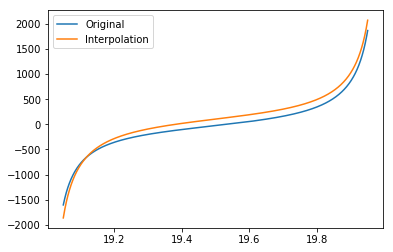

In [40]:
# Plot the rationnal interpolation between a[0] and a[1] in (a[0] + a[1]) / 2
x0 = (a[0] + a[1]) / 2

# Slight perturbation to avoid divergence on the plot
epsilon = 0.05
linspace = np.linspace(a[1] + epsilon, a[0] - epsilon, 1000)

# Rationnal interpolation
test_inter = lambda y: rationnal_interpolation(a, b, gamma, x0, y, 1)
values_inter = [test_inter(y) for y in linspace]

# Original function within the same bounds
test_spectral = lambda x: spectral_func(a, b, gamma, x)
values = [test_spectral(x) for x in linspace]

# Show
plt.plot(linspace, values, label="Original")
plt.plot(linspace, values_inter, label="Interpolation")
plt.legend()
plt.show()

/home/gauthier/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


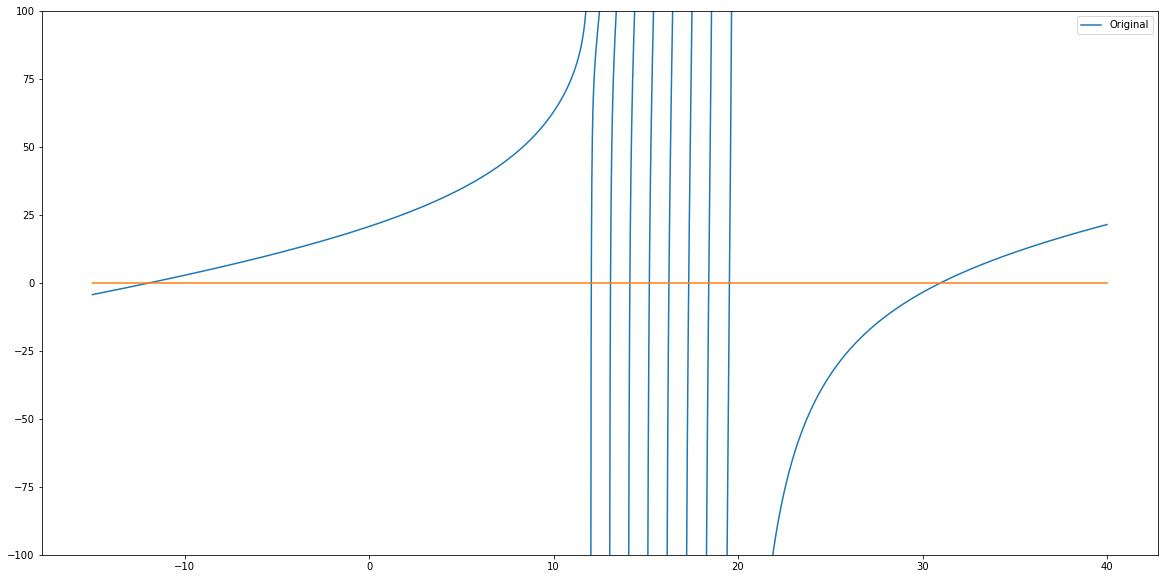

In [111]:
# Plot the whole function to observe where all the roots are located
linspace = np.linspace(-15, 40, 10000)

# We want to clip the highest values to avoid a vertical line at the discontinuity
def test_spectral_clipped (x, utol, ltol):
    y=spectral_func(a, b, gamma, x)
    if y>utol:
        y= np.inf
    if y<ltol:
        y= -np.inf
    return y

test_spectral = lambda x: spectral_func(a, b, gamma, x)
values = [test_spectral_clipped(x, 150, -150) for x in linspace]

# We also highlight the y axis
zero_axis= [0 for x in linspace]

# Show
plt.figure(figsize=(20,10))
plt.plot(linspace, values, label="Original")
plt.plot(linspace, zero_axis)
plt.legend()
axes = plt.gca()
axes.set_ylim([-100,100])

plt.show()

In [41]:
def interior_alpha(a, b, gamma, x, k):
    sig = interior_sigma_coef(a, b, gamma, x, k)
    deno = (a[k - 1] - x) * (x - a[k])
    return sig / deno

In [42]:
def exterior_alpha(a, b, gamma, x, k):
    somme = 0
    if k==0:
        for i in range (1,n-1):
            to_sum1 = (np.power(b[i],2)*(a[0]-a[i]))/np.power(x-a[i],3)
            somme +=  to_sum1
        return -(1+somme)/(x-a[0])
    else:
        for i in range (0,n-2):
            to_sum1 = (np.power(b[i],2)*(a[n-2]-a[i]))/np.power(x-a[i],3)
            somme +=  to_sum1
        return -(1+somme)/(x-a[n-2])
    return sig / deno

In [52]:
def interior_beta(a, b, gamma, x, k):
    prime = spectral_func_prime(a, b, x)
    fac = (1 / (a[k - 1] - x)) + (1 / (a[k] - x))
    func = spectral_func(a, b, gamma, x)
    return prime - fac * func

In [53]:
def exterior_beta(a, b, gamma, x, k):
    prime = spectral_func_prime(a, b, x)
    func = spectral_func(a, b, gamma, x)
    if k==0:
        return prime + func/(x-a[0])
    
    else:
        return prime - +func/(x-a[n-2])

In [54]:
# Verification for the result yielded by the program in cuda C:
x = np.zeros((n, ))
for i in range(1, n-1):
    x[i] = (a[i - 1] + a[i]) / 2
x[0] = a[0] + 5
x[n-1] = a[n-2] -5
print(x)
print([interior_sigma_coef(a, b, gamma, x[k], k) for k in range(1, n-1)])
print([interior_alpha(a, b, gamma, x[k], k) for k in range(1, n-1)])

[ 25.   19.5  18.5  17.5  16.5  15.5  14.5  13.5  12.5   7. ]
[-58.597130317727377, 21.154894609914255, 64.791961705038673, 88.162583914224115, 98.674449763444471, 100.50186944256433, 96.428511277568731, 88.613812356105356]
[-234.38852127090951, 84.619578439657019, 259.16784682015469, 352.65033565689646, 394.69779905377789, 402.00747777025731, 385.71404511027492, 354.45524942442142]


In [55]:
def interior_increment(a, b, gamma, x, k):
    f = spectral_func(a, b, gamma, x)
    beta = interior_beta(a, b, gamma, x, k)
    alpha = interior_alpha(a, b, gamma, x, k)
    term1 = 2 * f / beta
    term2 = 2 * alpha / beta
    deno = 1 + np.sqrt(1 + term1 * term2)
    return term1 / deno

In [56]:
def exterior_increment(a, b, gamma, x, k):
    f = spectral_func(a, b, gamma, x)
    beta = exterior_beta(a, b, gamma, x, k)
    alpha = exterior_alpha(a, b, gamma, x, k)
    term1 = 2 * f / beta
    term2 = 2 * alpha / beta
    deno = 1 + np.sqrt(1 + term1 * term2)
    return term1 / deno

In [81]:
def interior_zero_finder(a, b, gamma, x0, k, epsilon=0.000001, maxit=10000):
    i = 0
    dist = np.inf
    x = x0
    func_track = []
    x_track = []
    x_track.append(x0)
    func = spectral_func(a, b, gamma, x) 
    func_track.append(func)
    dist = func ** 2
    while (dist > epsilon) and (i < maxit):
        delta = interior_increment(a, b, gamma, x, k)
        x -= delta
        func = spectral_func(a, b, gamma, x) 
        dist = func ** 2
        func_track.append(func)
        x_track.append(x)
        i+=1
    return x, x_track, func_track

In [88]:
def exterior_zero_finder(a, b, gamma, x0, k, epsilon=0.000001, maxit=10000):
    i = 0
    dist = np.inf
    x = x0
    func_track = []
    x_track = []
    x_track.append(x0)
    func = spectral_func(a, b, gamma, x) 
    func_track.append(func)
    dist = func ** 2
    while (dist > epsilon) and (i < maxit):
        delta = exterior_increment(a, b, gamma, x, k)
        x -= delta
        func = spectral_func(a, b, gamma, x) 
        dist = func ** 2
        func_track.append(func)
        x_track.append(x)
        i+=1
    return x, x_track, func_track

In [89]:
# Verification for the result yielded by the program in cuda C:
x = np.zeros((n, ))
for i in range(1, n-1):
    x[i] = (a[i - 1] + a[i]) / 2
x[0] = a[0] + 5
x[n-1] = a[n-2] -5
interior_zeros_list = []

xopt, xtrack, functrack = exterior_zero_finder(a, b, gamma, x[0], 0)
interior_zeros_list.append(xopt)

for k in range(1, n-1):
    xopt, xtrack, functrack = interior_zero_finder(a, b, gamma, x[k], k)
    interior_zeros_list.append(xopt)

xopt, xtrack, functrack = exterior_zero_finder(a, b, gamma, x[n-1], n-2)
interior_zeros_list.append(xopt)

print(interior_zeros_list)

[30.963849050833353, 19.534149402457878, 18.412100122600613, 17.324193762504851, 16.252151433710413, 15.18981925383949, 14.134600930693026, 13.08570317358234, 12.04393665330867, -11.940401371322386]


In [86]:
# Check if the spectral function is close to zeros at the roots
error_list = [np.power(spectral_func(a, b, gamma, xopt),2) for xopt in interior_zeros_list]
print(error_list)

[6.2888812564153544e-08, 2.8021601530898693e-25, 3.2809875469824115e-17, 1.3644114426134346e-11, 3.9365865428803701e-09, 9.1477023351840754e-08, 6.0340515432936302e-07, 4.8240737620437402e-25, 2.4036907326446318e-25, 6.3531637139069346e-08]
